In [1]:
import json
from sklearn.metrics import cohen_kappa_score

def read_annotations(path):
    data = []

    with open(path) as f:
        for line in f:
            data.append(json.loads(line))
    return data


a1_annotations = read_annotations("../corpus/timebank/nt_format/tbd_a1.jsonl")
a2_annotations = read_annotations("../corpus/timebank/nt_format/tbd_a2.jsonl")

In [2]:
a1_annotations_by_id = {a["id"]: a for a in a1_annotations}
a2_annotations_by_id = {a["id"]: a for a in a2_annotations}

overlapping_ids = set(a1_annotations_by_id.keys()).intersection(set(a2_annotations_by_id.keys()))
total_ids = set(a1_annotations_by_id.keys()).union(set(a2_annotations_by_id.keys()))

print(f"Number of overlapping ids: {len(overlapping_ids)} / {len(total_ids)}")

Number of overlapping ids: 36 / 36


In [3]:
from collections import namedtuple

typeid2name = ["[B]", "[C]", "{U}", "[U}", "{U]", "[R>", "<R]", "[I]"]
name2typeid = {name: idx for idx, name in enumerate(typeid2name)}
Event = namedtuple("Event", ["id", "word_span"])

def get_events_by_span(events, timex, span, debug_info=None):
    debug_info = debug_info or ""
    all_events = []

    for event_idx, event in events.items():
        event_start, event_end = event  # 144, 144
        if event_start >= span[0] and event_end <= span[1]:
            all_events.append(Event(event_idx, event))

    for timex_idx, timex in timex.items():
        event_start, event_end = timex
        if event_start >= span[0] and event_end <= span[1]:
            all_events.append(Event(f"timex_{timex_idx}", timex))

    if len(all_events) == 0:
        print(f"{debug_info} No events found for span {span}")
    return all_events


def get_all_events_info(annotation, debug_info=None):
    events = annotation["events"]
    timex = annotation["timex"]
    all_events_order = annotation["event_order"]

    all_events_with_types = {}

    for event_order in all_events_order.values():
        _events = get_events_by_span(events, timex, event_order["span"], debug_info=debug_info)
        for _e in _events:
            all_events_with_types[_e.id] = event_order
    return all_events_with_types

event_info = get_all_events_info(a1_annotations[0])
print(next(iter(event_info.values())))
del event_info

{'span': [0, 19], 'type': 0, 'time': '6', 'branch': '', 'factuality': ''}


# Event type agreement

In [4]:
def remove_invisible_events(events, invisible_events):
    """To evaluate even type agreement we only compare visible events"""
    visible_events = {}
    for event_id, event in events.items():
        if any(e in event for e in invisible_events):
            continue
        visible_events[event_id] = event
    
    return visible_events

def replace_consecutive_with_bounded(events):
    """To evaluate even type agreement we only compare visible events"""
    fixed_events = {}
    for event_id, event in events.items():
        if event["type"] == name2typeid["[C]"]:
            event["type"] = name2typeid["[B]"]
        fixed_events[event_id] = event
    
    return fixed_events

In [5]:
import math
from copy import deepcopy
import krippendorff

doc2metrics = {}

all_a1_event_types = []
all_a2_event_types = []

for doc_id in overlapping_ids:
    a1_annotation = deepcopy(a1_annotations_by_id[doc_id])
    a2_annotation = deepcopy(a2_annotations_by_id[doc_id])

    a1_annotation["events"] = remove_invisible_events(a1_annotation["events"], a1_annotation["invisible_events"])
    a2_annotation["events"] = remove_invisible_events(a2_annotation["events"], a2_annotation["invisible_events"])

    a1_annotation["event_order"] = replace_consecutive_with_bounded(a1_annotation["event_order"])
    a2_annotation["event_order"] = replace_consecutive_with_bounded(a2_annotation["event_order"])

    assert a1_annotation["events"] == a2_annotation["events"]
    assert a1_annotation["timex"] == a2_annotation["timex"]

    events = a1_annotation["events"]
    timex = {f"timex_{k}": v for k, v in a1_annotation["timex"].items()}
    events = events | timex

    a1_event_info = get_all_events_info(a1_annotation, debug_info="a1")
    a2_event_info = get_all_events_info(a2_annotation, debug_info="a2")

    for event_id in events.keys():
        assert event_id in a1_event_info.keys(), f"Event {event_id} not found in a1"
        assert event_id in a2_event_info.keys(), f"Event {event_id} not found in a2"

    assert a1_event_info.keys() == a2_event_info.keys()

    a1_all_events_with_types = {k: v["type"] for k, v in a1_event_info.items()}
    a2_all_events_with_types = {k: v["type"] for k, v in a2_event_info.items()}
    assert a1_all_events_with_types.keys() == a2_all_events_with_types.keys()

    keys = list(a1_all_events_with_types.keys())
    a1_all_events_with_types_list = [a1_all_events_with_types[k] for k in keys]
    a2_all_events_with_types_list = [a2_all_events_with_types[k] for k in keys]

    # add to all-list to compute corpus-level agreement
    all_a1_event_types.extend(a1_all_events_with_types_list)
    all_a2_event_types.extend(a2_all_events_with_types_list)

    acc = sum(int(a1 == a2) for a1, a2 in zip(a1_all_events_with_types_list, a2_all_events_with_types_list))
    acc /= len(a1_all_events_with_types_list)

    try:
        krippendorff_kappa = krippendorff.alpha([a1_all_events_with_types_list, a2_all_events_with_types_list], level_of_measurement="nominal")
    except AssertionError:
        krippendorff_kappa = math.nan

    kohen_kappa = cohen_kappa_score(a1_all_events_with_types_list, a2_all_events_with_types_list)

    doc2metrics[doc_id] = {
        "accuracy": acc,
        "krippendorff kappa": krippendorff_kappa,
        "kohen kappa": kohen_kappa
    }

print(f"Corpus-level agreement")
print(f"\tKohen kappa: {cohen_kappa_score(all_a1_event_types, all_a2_event_types):.2f}")
print(f"\tAccuracy: {sum(int(a1 == a2) for a1, a2 in zip(all_a1_event_types, all_a2_event_types)) / len(all_a1_event_types):.2f}")
print(f"\tKrippendorff kappa: {krippendorff.alpha([all_a1_event_types, all_a2_event_types], level_of_measurement='nominal'):.2f}")

Corpus-level agreement
	Kohen kappa: 0.62
	Accuracy: 0.88
	Krippendorff kappa: 0.62


/Users/vladislavlialin/miniconda3/envs/nt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:663: RuntimeWarning: invalid value encountered in double_scalars
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [110]:
# save as json
with open("event_type_agreement.json", "w") as f:
    json.dump(doc2metrics, f, indent=4)

In [112]:
# Top 3 least accurate documents
print(f"Top 3 most disagreable documents")
doc2acc = {k: v["krippendorff kappa"] for k, v in doc2metrics.items()}
for doc_id, acc in sorted(doc2acc.items(), key=lambda x: x[1])[:3]:
    print(f"\t{doc_id}: {acc:.2f}")

Top 3 most disagreable documents
	CNN19980213.2130.0155: 0.79
	ABC19980114.1830.0611: nan
	PRI19980121.2000.2591: -0.11


([<matplotlib.axis.YTick at 0x7ff6e1fb19d0>,
 [Text(0, 0, '[B]'), Text(0, 1, '{U}'), Text(0, 2, '[U}'), Text(0, 3, '{U]')])

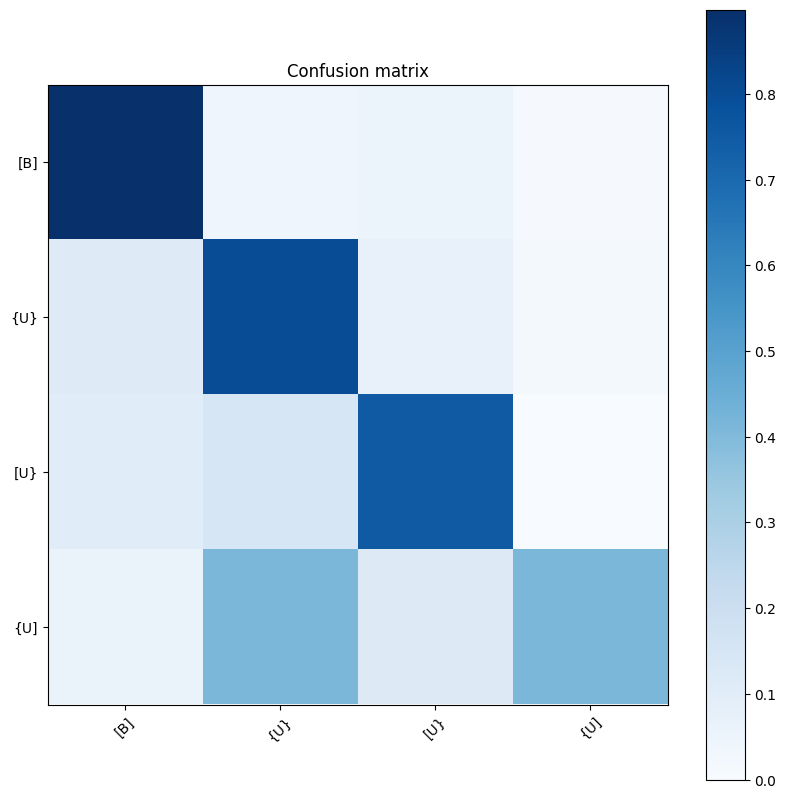

In [108]:
# plot confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# typeid2name
event_types = ["[B]", "{U}", "[U}", "{U]"]

cm = confusion_matrix(all_a1_event_types, all_a2_event_types)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(event_types))
plt.xticks(tick_marks, event_types, rotation=45)
plt.yticks(tick_marks, event_types)

# Event order agreement (WIP)
To get the order of events (their relationship) agreement, we need to place them on the timeline and then compare them. But because there could be multiple branched timelines and they can start/end at different events, it's easier to to compare them in TimeML format.

In [88]:
from nt2tml_v2 import convert_to_timeml

ModuleNotFoundError: No module named 'nt2tml_v2'

In [89]:
from collections import defaultdict

_id = next(iter(overlapping_ids))

a1_soup = convert_to_timeml(a1_annotations_by_id[_id], corpus_offset=0, silent=True)
a2_soup = convert_to_timeml(a2_annotations_by_id[_id], corpus_offset=0, silent=True)

a1_tlinks = a1_soup.find_all("TLINK")
a2_tlinks = a2_soup.find_all("TLINK")


def get_event_instance_id(tlink):
    if tlink.has_attr("eventInstanceID"):
        return tlink["eventInstanceID"]
    return None

def get_event_text(eiid, soup):
    """
    extract eventInstanceID (if exists) and lid
    if eventInstanceID, lookup eventID in MAKEINSTANCE given eventInstanceID then extract EVENT with this eventID
    else, extract TIMEX with lid
    """
    eid = soup.find("MAKEINSTANCE", {"eiid": eiid})["eventID"]
    event = soup.find("EVENT", {"eid": eid})
    return event


a1_eeid2event = {}
a1_eeid2tlinks = defaultdict(list)
for tlink in a1_tlinks:
    eiid = get_event_instance_id(tlink)
    if eiid is not None:
        event = get_event_text(eiid, a1_soup)
        a1_eeid2event[eiid] = event
        a1_eeid2tlinks[eiid].append(tlink)

a2_eeid2event = {}
a2_eeid2tlinks = defaultdict(list)
for tlink in a2_tlinks:
    eiid = get_event_instance_id(tlink)
    if eiid is not None:
        event = get_event_text(eiid, a2_soup)
        a2_eeid2event[eiid] = event
        a2_eeid2tlinks[eiid].append(tlink)

assert a1_eeid2event.keys() == a2_eeid2event.keys()
for k in a1_eeid2event.keys():
    assert a1_eeid2event[k].text == a2_eeid2event[k].text

event_ids = list(a1_eeid2event.keys())

NameError: name 'convert_to_timeml' is not defined

In [90]:
from itertools import product

# Do we have relations for every pair of events? Yes and no, some links are bidirectional
a1_event_to_event_rels = {}
for left_event_id in event_ids:
    event_tlinks = a1_eeid2tlinks[left_event_id]
    possible_relations = set(event_ids) - {left_event_id}
    for tlink in event_tlinks:
        if not "relatedToEventInstance" in tlink.attrs: continue
        right_event_id = tlink["relatedToEventInstance"]
        possible_relations.remove(right_event_id)
        key = (left_event_id, right_event_id)
        a1_event_to_event_rels[key] = tlink["relType"]
    
    a1_original_relations_set = set(a1_event_to_event_rels.keys())
    for right_event_id in possible_relations:
        key = (left_event_id, right_event_id)
        a1_event_to_event_rels[key] = "NONE"


a2_event_to_event_rels = {}
for left_event_id in event_ids:
    event_tlinks = a2_eeid2tlinks[left_event_id]
    possible_relations = set(event_ids) - {left_event_id}
    for tlink in event_tlinks:
        if not "relatedToEventInstance" in tlink.attrs: continue
        right_event_id = tlink["relatedToEventInstance"]
        possible_relations.remove(right_event_id)
        key = (left_event_id, right_event_id)
        a2_event_to_event_rels[key] = tlink["relType"]

    a2_original_relations_set = set(a2_event_to_event_rels.keys())
    for right_event_id in possible_relations:
        key = (left_event_id, right_event_id)
        a2_event_to_event_rels[key] = "NONE"

assert a1_original_relations_set == a2_original_relations_set

NameError: name 'event_ids' is not defined

In [49]:
len(a1_original_relations_set), len(a1_event_to_event_rels)

(4915, 4970)

In [50]:
len(a2_original_relations_set), len(a2_event_to_event_rels)

(4915, 4970)

In [41]:
print(len(a1_event_to_event_rels), len(a1_eeid2event.keys()) ** 2 - len(a1_eeid2event.keys()))
print(len(a2_event_to_event_rels), len(a2_eeid2event.keys()) ** 2 - len(a2_eeid2event.keys()))

4970 4970
4970 4970


In [44]:
from sklearn.metrics import cohen_kappa_score


a1_relations_ordered = []
a2_relations_ordered = []

for left_event in event_ids:
    for right_event in event_ids:
        if left_event == right_event: continue
        key = (left_event, right_event)
        a1_relations_ordered.append(a1_event_to_event_rels[key])
        a2_relations_ordered.append(a2_event_to_event_rels[key])

cohen_kappa_score(a1_relations_ordered, a2_relations_ordered)

1.0